# Permutations - NB: All models are indiscrimately trained over 10 epochs
Book and embedding length - remember to restart kernel everytime
- [x] 2450
    - [x] 4000
    - [x] 2000
    - [x] 1000
- [x] ww2
    - [x] 4000
    - [x] 2000
    - [x] 1000

In [1]:
# Define embeddings - remember to change the embeddings file to 1000, 2000 or 4000
# Select context, context_medium or context_long depending on 1000, 2000 or 4000
SAVE_RESULTS = False
embedding_length = [1000, 2000, 4000][2]
book = [2450, 'ww2'][1]
ctx_length_to_name = {1000: 'context', 2000: 'context_medium', 4000: 'context_long'}

# use cuda
import torch
import tensorflow as tf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# Imports
import numpy as np
import pandas as pd
import pickle
import random

# set randomn seed for reproducibility
seed = 23
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
tf.random.set_seed(seed)

from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
from keras.models import load_model
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt


from tqdm import tqdm

from sklearn.metrics import roc_curve, roc_auc_score

# use cuda
model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-dot-v1').to(device)

c:\Users\PC\miniconda3\envs\cuda_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Get data
with open(f'./data/{book}.pkl', 'rb') as f:
    df_data = pickle.load(f)
df_data.reset_index(inplace=True)

In [4]:
u_ctx_short = df_data['context'].unique()

ctx_mapping_short_to_medium = {}

for i in range(len(u_ctx_short)-1):
    if i % 2 == 0:
        ctx_mapping_short_to_medium[u_ctx_short[i]] = u_ctx_short[i]+u_ctx_short[i+1]
    else:
        ctx_mapping_short_to_medium[u_ctx_short[i]] = u_ctx_short[i-1]+u_ctx_short[i]

data = []
for ctx in df_data['context']:
    val = ctx_mapping_short_to_medium.get(ctx)
    if val:
        data.append(val)
    else:
        data.append(ctx)

df_data['context_medium'] = data

u_ctx_medium = df_data['context_medium'].unique()

ctx_mapping_medium_to_long = {}

n = len(u_ctx_medium)
for i in range(n-1,0,-1):
    if i % 2 == n % 2:
        ctx_mapping_medium_to_long[u_ctx_medium[i]] = u_ctx_medium[i]+u_ctx_medium[i+1]
    else:
        ctx_mapping_medium_to_long[u_ctx_medium[i]] = u_ctx_medium[i-1]+u_ctx_medium[i]

data = []
for ctx in df_data['context_medium']:
    val = ctx_mapping_medium_to_long.get(ctx)
    if val:
        data.append(val)
    else:
        data.append(ctx)

df_data['context_long'] = data

In [5]:
# # Make embeddings
# question_embeddings = {q: model.encode(q) for q in df_data['question'].unique()}
# with open(f'./Embeddings/{book}_question_embeddings.pkl', 'wb') as f:
#     f.write(pickle.dumps(question_embeddings))

# context_embeddings_1000 = {ctx: model.encode(ctx) for ctx in df_data['context'].unique()}
# with open(f'./Embeddings/{book}_context_embeddings_1000.pkl', 'wb') as f:
#     f.write(pickle.dumps(context_embeddings_1000))

# context_embeddings_2000 = {ctx: model.encode(ctx) for ctx in df_data['context_medium'].unique()}
# with open(f'./Embeddings/{book}_context_embeddings_2000.pkl', 'wb') as f:
#     f.write(pickle.dumps(context_embeddings_2000))

# context_embeddings_4000 = {ctx: model.encode(ctx) for ctx in df_data['context_long'].unique()}
# with open(f'./Embeddings/{book}_context_embeddings_4000.pkl', 'wb') as f:
#     f.write(pickle.dumps(context_embeddings_4000))

In [6]:
with open(f'./Embeddings/{book}_context_embeddings_{embedding_length}.pkl', 'rb') as f:
    context_embeddings = pickle.loads(f.read())
with open(f'./Embeddings/{book}_question_embeddings.pkl', 'rb') as f:
    question_embeddings = pickle.loads(f.read())

In [30]:
# get value of some entree
print(list(question_embeddings.values())[0].shape)

(768,)


In [7]:
# Make combinations
from collections import defaultdict

is_added = defaultdict(lambda: 0)

contexts = df_data[ctx_length_to_name[embedding_length]].unique()
data = []

for i,row in df_data.iterrows():
    if is_added[row['question']]:
        continue

    dft = pd.DataFrame(columns=['context', 'question', 'label'])
    dft['context'] = contexts
    dft['question'] = row['question']
    dft['label'] = 0

    for ctx in df_data.loc[df_data['question'] == row['question'], ctx_length_to_name[embedding_length]]:
        dft.loc[dft['context']==ctx,'label'] = 1

    data.append(dft)

    is_added[row['question']] = 1
df = pd.concat(data, ignore_index=True)
sum(df['label'])

1255

In [8]:
# Select for train and test
n_test_q = int(0.2*len(df['question'].unique()))
test_q = np.random.choice(df['question'].unique(), n_test_q, replace=False)

# Make dataframes for repeated contexts
df_test_all_ctx = df.loc[df['question'].isin(test_q)]
df_test_all_ctx.reset_index(inplace=True, drop=True)
df_par_all_ctx =  df.loc[~df['question'].isin(test_q)]
df_par_all_ctx.reset_index(inplace=True, drop=True)

# Select validation questions
n_val_q = int(0.1*len(df_par_all_ctx['question'].unique()))
val_q = np.random.choice(df_par_all_ctx['question'].unique(), n_val_q, replace=False)

# Make dataframes for train and validation
df_val_all_ctx =  df_par_all_ctx.loc[df_par_all_ctx['question'].isin(val_q)]
df_val_all_ctx.reset_index(inplace=True, drop=True)
df_train_all_ctx =  df_par_all_ctx.loc[~df_par_all_ctx['question'].isin(val_q)]
df_train_all_ctx.reset_index(inplace=True, drop=True)

# Make train and test data - Context and question are concatenated together
X_train_all_ctx = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_train_all_ctx['context'].values, df_train_all_ctx['question'].values)])
y_train_all_ctx = np.array([i for i in df_train_all_ctx['label'].values])

X_val_all_ctx = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_val_all_ctx['context'].values, df_val_all_ctx['question'].values)])
y_val_all_ctx = np.array([i for i in df_val_all_ctx['label'].values])

X_test_all_ctx = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_test_all_ctx['context'].values, df_test_all_ctx['question'].values)])
y_test_all_ctx = np.array([i for i in df_test_all_ctx['label'].values])

# Shuffle
idx_train_all_ctx = np.random.permutation(len(X_train_all_ctx))
X_train_all_ctx = X_train_all_ctx[idx_train_all_ctx]
y_train_all_ctx = y_train_all_ctx[idx_train_all_ctx]

idx_val_all_ctx = np.random.permutation(len(X_val_all_ctx))
X_val_all_ctx = X_val_all_ctx[idx_val_all_ctx]
y_val_all_ctx = y_val_all_ctx[idx_val_all_ctx]

idx_test_all_ctx = np.random.permutation(len(X_test_all_ctx))
X_test_all_ctx = X_test_all_ctx[idx_test_all_ctx]
y_test_all_ctx = y_test_all_ctx[idx_test_all_ctx]

In [9]:
# # Save data
if SAVE_RESULTS:
    with open(f'./Results/{embedding_length}/y_labels_{book}', 'wb') as f:
        f.write(pickle.dumps(y_test_all_ctx))

In [14]:
# # load data
# with open(f'./Results/{embedding_length}/y_labels_{book}', 'rb') as f:
#     y_test_all_ctx = pickle.loads(f.read())

In [9]:
# Define NN
neural_net_b = Sequential()
neural_net_b.add(Dense(768, input_dim=768*2, activation='relu'))
neural_net_b.add(Dense(384, activation='relu'))
neural_net_b.add(Dense(1, activation='sigmoid'))

neural_net_b.compile(loss='binary_crossentropy', optimizer='adam', metrics=[metrics.TruePositives(name='tp'),
                metrics.FalsePositives(name='fp'),
                metrics.TrueNegatives(name='tn'),
                metrics.FalseNegatives(name='fn'),
                metrics.BinaryAccuracy(name='accuracy'),
                metrics.Precision(name='precision'),
                metrics.Recall(name='recall'),
                metrics.AUC(name='auc'),
                metrics.AUC(name='prc', curve='PR')])

# Train NN
history_basic = neural_net_b.fit(X_train_all_ctx, y_train_all_ctx, batch_size=128, epochs=10, validation_data=(X_val_all_ctx, y_val_all_ctx))
neural_net_b.save(f'./Results/{embedding_length}/hist_nn_{book}')

# Test NN
y_nnb_preds = neural_net_b.predict(X_test_all_ctx)

# Save results
if SAVE_RESULTS:
    with open(f'./Results/{embedding_length}/nn_preds_{book}', 'wb') as f:
        f.write(pickle.dumps(y_nnb_preds))

    with open(f'./Results/{embedding_length}/nn_hist_{book}', 'wb') as f:
        f.write(pickle.dumps(history_basic))

Epoch 1/10
452/452 [==============================] - 6s 11ms/step - loss: 0.0859 - tp: 0.0000e+00 - fp: 30.0000 - tn: 56922.0000 - fn: 904.0000 - accuracy: 0.9839 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4983 - prc: 0.0158 - val_loss: 0.0772 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6300.0000 - val_fn: 100.0000 - val_accuracy: 0.9844 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7254 - val_prc: 0.0394
Epoch 2/10
452/452 [==============================] - 4s 9ms/step - loss: 0.0743 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 56952.0000 - fn: 904.0000 - accuracy: 0.9844 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7420 - prc: 0.0490 - val_loss: 0.0747 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6300.0000 - val_fn: 100.0000 - val_accuracy: 0.9844 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7761 - val_prc: 0.0450
Epoch 3/10
452/452 [==============================] - 4s 8ms/step - loss: 0.0674 - tp: 0.0000e+00 - 

In [21]:

with open(f'./Results/{embedding_length}/nn_preds_{book}', 'rb') as f:
    y_nnb_preds = pickle.loads(f.read())

In [ ]:
# Load history_basic
with open(f'./Results/{embedding_length}/nn_hist_{book}', 'rb') as f:
    history_basic = pickle.loads(f.read())

In [ ]:
with open(f'dev/Neural Search/Results/4000/nn_hist_2450', 'rb') as f:
    history_basic = pickle.loads(f.read())

In [ ]:
# Load model
neural_net_b = load_model(f'./Results/{embedding_length}/hist_nn_{book}')

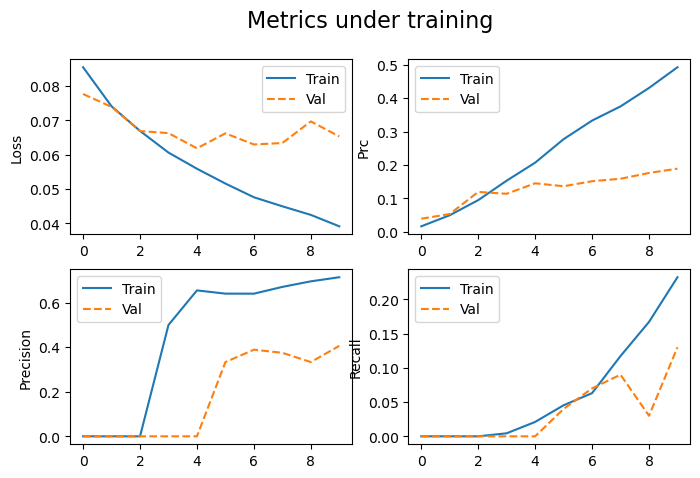

In [50]:
metrics =  ['loss', 'prc', 'precision', 'recall']
def plot_metrics(history):
    fig, axes = plt.subplots(2, 2, figsize=(8, 5))
    # fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Metrics under training', fontsize=16)
    axes = axes.flatten()
    for i, m in enumerate(metrics):

        axes[i].plot(history.history[m], label='Train')
        axes[i].plot(history.history['val_'+m], linestyle="--", label='Val')
        axes[i].legend()
        name = m.replace("_"," ").capitalize()
        axes[i].set_ylabel(name)
    

    # axes[metrics.index('loss')].set_ylim(0, plt.ylim()[1])
    # axes[metrics.index('auc')].set_ylim(0.8, 1)
    
    # fig.tight_layout()
    plt.show()


plot_metrics(history_basic)

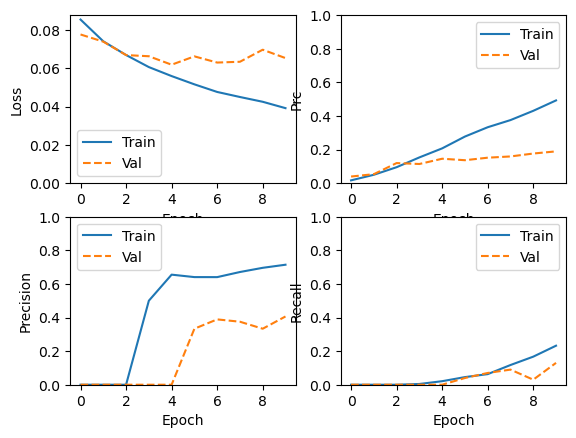

In [33]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
  


  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
              linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    plt.legend()

plot_metrics(history_basic)

In [7]:
plot_metrics(history_basic)

NameError: name 'history_basic' is not defined

In [15]:
# Weighted dot-product
learning_rate = 0.2
loss_list = []
val_list = []

T = tf.Variable(np.ones(X_train_all_ctx.shape[1]//2))

len_train = X_train_all_ctx.shape[0]

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

batch_size = 128
itt = int(np.ceil(len_train/batch_size))
n_epochs = 10

loss = tf.keras.losses.mean_squared_error

with tqdm(total=itt*n_epochs) as pbar:
    for _ in range(n_epochs):
        for i in range(1,itt+1):
            low = (i-1)*batch_size
            high = min(i*batch_size, len_train)

            a = X_train_all_ctx[low:high,:1536//2]
            b = X_train_all_ctx[low:high,1536//2:]

            y_true = y_train_all_ctx[low:high]
            
            with tf.GradientTape() as tape:
                tape.watch(T)  # Watch the variable T for gradient computation
                W = tf.exp(T)
                y_preds = tf.math.reduce_sum(a*W*b, axis=1)
                error = loss(y_true, y_preds)

            gradients = tape.gradient(error, T)
            optimizer.apply_gradients([(gradients, T)])
            loss_list.append(error.numpy())
            pbar.update(1)
    
        W_val = tf.exp(T)
        y_val_preds = tf.math.reduce_sum(X_val_all_ctx[:,:1536//2].astype(np.float32)*W_val*X_val_all_ctx[:,1536//2:].astype(np.float32), axis=1)
        val_list.append(loss(y_val_all_ctx, y_val_preds).numpy())

loss_list_epochs = []
for i in range(n_epochs):
    loss_list_epochs.append(np.mean(loss_list[i*itt:(i+1)*itt]))

100%|██████████| 31810/31810 [02:47<00:00, 189.97it/s]


In [16]:
# Save weight information
if SAVE_RESULTS:
    with open(f'./Results/{embedding_length}/dot_weights_{book}', 'wb') as f:
        f.write(pickle.dumps(T))

    with open(f'./Results/{embedding_length}/weight_loss_{book}', 'wb') as f:
        f.write(pickle.dumps(loss_list_epochs))

    with open(f'./Results/{embedding_length}/weight_val_{book}', 'wb') as f:
        f.write(pickle.dumps(val_list))

In [17]:
# Weight predictions
W_test = tf.exp(T)
y_weight_preds = tf.math.reduce_sum(X_test_all_ctx[:,:1536//2].astype(np.float32)*W_test*X_test_all_ctx[:,1536//2:].astype(np.float32), axis=1)

In [18]:
# Dot predictions
y_dot_preds = [np.dot(a, b) for a,b in zip(X_test_all_ctx[:,:1536//2], X_test_all_ctx[:,1536//2:])]

In [19]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)
  plt.plot(fp, tp, label=f'{name} AUC: {roc_auc_score(labels, predictions):.3f}', linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.05,1])
  plt.ylim([0,1.05])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

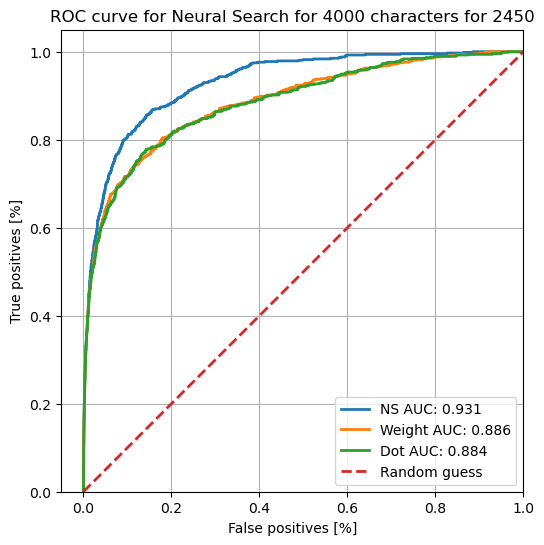

In [20]:
# Plot ROC curve
plt.figure(figsize=(10,6))
plot_roc("NS", y_test_all_ctx, y_nnb_preds)
plot_roc("Weight", y_test_all_ctx, y_weight_preds)
plot_roc("Dot", y_test_all_ctx, y_dot_preds)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, label='Random guess')
plt.title(f"ROC curve for Neural Search for {embedding_length} characters for {book}")
plt.legend(loc='lower right')
plt.savefig(f'./Results/{embedding_length}/search_{embedding_length}_{book}.png')
plt.show()

In [21]:
print(book, embedding_length)


2450 4000


## Visualizing context extraction

In [10]:
# Sample a random question from the training data
random_idx = np.random.randint(0, len(X_train_all_ctx))
random_question = X_train_all_ctx[random_idx]
random_answer = y_train_all_ctx[random_idx]

In [11]:
query = random_question[:len(random_question)//2]

In [14]:
# First half is context, second half is question
random_idx = np.random.randint(0, len(X_train_all_ctx))
random_question = X_train_all_ctx[random_idx]
query = random_question[:len(random_question)//2]
query_book = np.array([np.concatenate((x[len(x)//2:], query)) for x in X_train_all_ctx]) 

In [15]:
output = neural_net_b.predict(query_book)

1808/1808 [==============================] - 3s 1ms/step


In [34]:
output.shape

(57856, 1)

In [35]:
output[:10].shape

(10, 1)

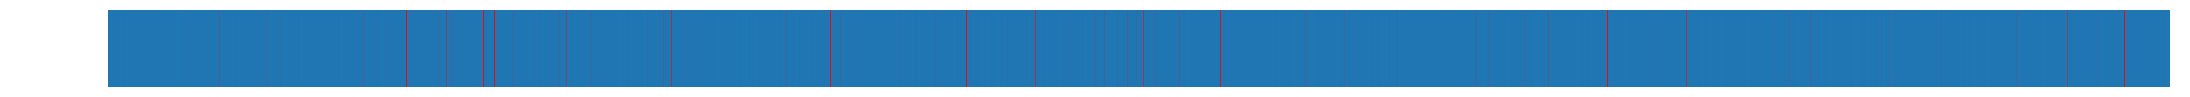

In [44]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Get top param: n contexts,
# increase color intensity for higher values (dot product normalized)
# How to normalize? Standardize entire output?
def main(values, title="", size=(14, 1), linewidth=2):
    values = (values - values.min())/(values.max() - values.min())

    fig, ax = plt.subplots(figsize=size)
    for i, v in enumerate(values):
        ax.axvline(i, color=colorFader('#1f77b4', 'red', v), linewidth=linewidth) 

    if title:
        plt.title(title, fontsize=15)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.axis('off')
    plt.show()

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

# main(output, "len = 1", 1)
# main(output, "len = 2", 2)
main(output, "", (28,1), 2)
# main(output, "", (28,1), 2, True)